In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from helper import *

# Prepare data

In [2]:
df = pd.read_csv('../data/historical_data/cleaned_data.csv')
print(df.shape)
df.head()

(525663, 51)


,raceid,Time,KakuteiJyuni,DochakuKubun,DochakuTosu,Umaban,KettoNum,KeiroCD,Barei,ChokyosiCode,...,MinaraiCD_1,MinaraiCD_2,MinaraiCD_3,JyokenInfo$JyuryoCD_1.0,JyokenInfo$JyuryoCD_2.0,JyokenInfo$JyuryoCD_3.0,JyokenInfo$JyuryoCD_4.0,TrackCD_Dirt,TrackCD_Jump,TrackCD_Turf
0,2008-01-05 01:06,752,8,0,0,1,2005107051,3,3,437,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2008-01-05 01:06,739,1,0,0,2,2005102028,3,3,138,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2008-01-05 01:06,742,3,0,0,3,2005104156,3,3,1054,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2008-01-05 01:06,749,6,0,0,4,2005105319,3,3,1081,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2008-01-05 01:06,739,2,0,0,5,2005101044,3,3,1088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
df['raceid'].apply(lambda x: True if x.split('-')[0] == '2018' else False).sum()

In [3]:
drop_cols = [
'IJyoCD', 
'KeiroCD', 
'ChokyosiCode', 
'Honsyokin',
'KettoNum',
'Time', 
'raceid', 
'racedate', 
'KakuteiJyuni', 
'KakuteiJyuni_fixed', 
'Top 1', 
'Top 3', 
'Speed', 
'Speed_fixed', 
'DochakuKubun', 
'DochakuTosu',
'KisyuCode']

In [ ]:
X_train, X_test, y_train, y_test, top3_train, top3_test, raceid_train, raceid_test = split_data(df.reset_index(drop=True), target_col='Top 3',
                                                                                                drop_columns=drop_cols,
                                                                                                select_cols=None,
                                                                                                test_size=25402)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

# Metrics

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
def top3_accuracy_score(y_true, y_pred):
    return y_pred[y_true].sum()/y_true.sum()

# Baseline model

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

In [ ]:
model_Log = LogisticRegression(max_iter=300)
model_Log.fit(scaler.transform(X_train), y_train)

In [ ]:
top3_pred = predict_top3_prob(model_Log, scaler.transform(X_test), raceid_test)
print('Total accuracy:', accuracy_score(top3_test, top3_pred['Top 3']))
print('Top 3 prediction accuracy:', top3_accuracy_score(top3_test.values, top3_pred['Top 3'].values))

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(height=model_Log.coef_[0], x = X_train.columns)
xticks = plt.xticks(rotation=90)

# Better model

## Calculate some fields

In [9]:
horse_exp = generate_exp('KettoNum')
df['Horse_exp'] = df.apply(horse_exp.generate_exp, axis=1)

top3_horse = generate_exp('KettoNum', val='Top 3')
df['Horse_top3'] = df.apply(top3_horse.generate_exp, axis=1)

horse_last_5 = generate_exp('KettoNum', val='KakuteiJyuni_fixed', k=5, init_val=250.)
df['Horse_last_5'] = df.apply(horse_last_5.generate_last_k_exp, axis=1)
horse_last_3 = generate_exp('KettoNum', val='KakuteiJyuni_fixed', k=3, init_val=150.)
df['Horse_last_3'] = df.apply(horse_last_3.generate_last_k_exp, axis=1)
horse_last_1 = generate_exp('KettoNum', val='KakuteiJyuni_fixed', k=1, init_val=50.)
df['Horse_last_1'] = df.apply(horse_last_1.generate_last_k_exp, axis=1)

horse_last_3_top3 = generate_exp('KettoNum', val='Top 3', k=3, init_val=0.6)
df['Horse_last_3_top3'] = df.apply(horse_last_3_top3.generate_last_k_exp, axis=1)

horse_last_3_top1 = generate_exp('KettoNum', val='Top 1', k=3, init_val=0.)
df['Horse_last_3_top1'] = df.apply(horse_last_3_top1.generate_last_k_exp, axis=1)

horse_last_3_speed = generate_exp('KettoNum', val='Speed_fixed', k=3, init_val=1.6*3)
df['Horse_last_3_speed'] = df.apply(horse_last_3_speed.generate_last_k_exp, axis=1)

##################
jockey_exp = generate_exp('KisyuCode')
df['Jockey_exp'] = df.apply(jockey_exp.generate_exp, axis=1)

top3_jockey = generate_exp('KisyuCode', val='Top 3')
df['Jockey_top3'] = df.apply(top3_jockey.generate_exp, axis=1)

jockey_last_5 = generate_exp('KisyuCode', val='KakuteiJyuni_fixed', k=5, init_val=250.)
df['Jockey_last_5'] = df.apply(jockey_last_5.generate_last_k_exp, axis=1)
jockey_last_10 = generate_exp('KisyuCode', val='KakuteiJyuni_fixed', k=10, init_val=500.)
df['Jockey_last_10'] = df.apply(jockey_last_10.generate_last_k_exp, axis=1)

jockey_last_5_top3 = generate_exp('KisyuCode', val='Top 3', k=5, init_val=1.)
df['Jockey_last_5_top3'] = df.apply(jockey_last_5_top3.generate_last_k_exp, axis=1)
jockey_last_10_top3 = generate_exp('KisyuCode', val='Top 3', k=10, init_val=2.)
df['Jockey_last_10_top3'] = df.apply(jockey_last_10_top3.generate_last_k_exp, axis=1)

jockey_last_5_top1 = generate_exp('KisyuCode', val='Top 1', k=5, init_val=.15)
df['Jockey_last_5_top1'] = df.apply(jockey_last_5_top1.generate_last_k_exp, axis=1)

jockey_last_5_speed = generate_exp('KisyuCode', val='Speed_fixed', k=5, init_val=1.6*5)
df['Jockey_last_5_speed'] = df.apply(jockey_last_5_speed.generate_last_k_exp, axis=1)

##################
coach_exp = generate_exp('ChokyosiCode', val='Top 3')
df['Coach_exp'] = df.apply(coach_exp.generate_exp, axis=1)

In [6]:
df = pd.read_csv('temp.csv')
df.head(2)

,raceid,Time,KakuteiJyuni,DochakuKubun,DochakuTosu,Umaban,KettoNum,KeiroCD,Barei,ChokyosiCode,...,Horse_last_3_speed,Jockey_exp,Jockey_top3,Jockey_last_5,Jockey_last_10,Jockey_last_5_top3,Jockey_last_10_top3,Jockey_last_5_top1,Jockey_last_5_speed,Coach_exp
0,2008-01-05 01:06,752,8,0,0,1,2005107051,3,3,437,...,4.8,0.0,0.0,250.0,500.0,1.0,2.0,0.15,8.0,0.0
1,2008-01-05 01:06,739,1,0,0,2,2005102028,3,3,138,...,4.8,0.0,0.0,250.0,500.0,1.0,2.0,0.15,8.0,0.0


In [7]:
df['Horse top 3 rate'] = df['Horse_top3']/(df['Horse_exp'] + 1e-6)
df['Jockey top 3 rate'] = df['Jockey_top3']/(df['Jockey_exp'] + 1e-6)
df.isna().sum().sum()

0

## Split data

In [8]:
X_train, X_test, y_train, y_test, top3_train, top3_test, raceid_train, raceid_test = split_data(df.reset_index(drop=True), target_col='Top 3',
                                                                                                drop_columns=drop_cols,
                                                                                                select_cols=None,
                                                                                                test_size=25402)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

(500261, 54) (500261,)
(25402, 54) (25402,)


,Umaban,Barei,Futan,Blinker,BaTaijyu,Zogen,Kyori,UmaKigoCD_0,UmaKigoCD_1,UmaKigoCD_5,...,Jockey_top3,Jockey_last_5,Jockey_last_10,Jockey_last_5_top3,Jockey_last_10_top3,Jockey_last_5_top1,Jockey_last_5_speed,Coach_exp,Horse top 3 rate,Jockey top 3 rate
0,1,3,540,0,428,12.0,1200.0,1.0,0.0,0.0,...,0.0,250.0,500.0,1.0,2.0,0.15,8.0,0.0,0.0,0.0
1,2,3,540,0,450,-10.0,1200.0,1.0,0.0,0.0,...,0.0,250.0,500.0,1.0,2.0,0.15,8.0,0.0,0.0,0.0
2,3,3,540,0,458,4.0,1200.0,1.0,0.0,0.0,...,0.0,250.0,500.0,1.0,2.0,0.15,8.0,0.0,0.0,0.0
3,4,3,540,0,402,-10.0,1200.0,1.0,0.0,0.0,...,0.0,250.0,500.0,1.0,2.0,0.15,8.0,0.0,0.0,0.0
4,5,3,540,0,482,2.0,1200.0,1.0,0.0,0.0,...,0.0,250.0,500.0,1.0,2.0,0.15,8.0,0.0,0.0,0.0


## Model

In [12]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [13]:
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [21]:
model_Log = LogisticRegression(max_iter=500, penalty='l2', C=0.1)
model_Log.fit(X_train_sc, y_train)

LogisticRegression(C=0.1, max_iter=500)

In [22]:
top3_pred_test = predict_top3_prob(model_Log, X_test_sc, raceid_test)
print('Total accuracy:', accuracy_score(top3_test, top3_pred_test['Top 3']))
print('Top 3 prediction accuracy:', top3_accuracy_score(top3_test.values, top3_pred_test['Top 3'].values))

Total accuracy: 0.77241949452799
Top 3 prediction accuracy: 0.45


In [17]:
min_prob_top3_test = top3_pred_test[top3_pred_test['Top 3']].groupby('raceid').agg({'Top 3 prob':'min'})
min_prob_top3_test.head()

,Top 3 prob
raceid,
2018-01-06 01:06,0.401591
2018-01-06 01:08,0.290500
2018-01-06 02:06,0.326496
2018-01-06 02:08,0.392221
2018-01-06 03:06,0.190505


In [18]:
top3_pred_train = predict_top3_prob(model_Log, scaler.transform(X_train), raceid_train)
print('Total accuracy:', accuracy_score(top3_train, top3_pred_train['Top 3']))
print('Top 3 prediction accuracy:', top3_accuracy_score(top3_train.values, top3_pred_train['Top 3'].values))

Total accuracy: 0.7707636613687655
Top 3 prediction accuracy: 0.44664020195402077


In [19]:
min_prob_top3_train = top3_pred_train[top3_pred_train['Top 3']].groupby('raceid').agg({'Top 3 prob':'min'})

In [20]:
min_prob_top3 = pd.concat([min_prob_top3_train,min_prob_top3_test], axis=0)
df = pd.merge(left=df, right=min_prob_top3, left_on='raceid', right_on='raceid', how='left')
df.head(2)

,raceid,Time,KakuteiJyuni,DochakuKubun,DochakuTosu,Umaban,KettoNum,KeiroCD,Barei,ChokyosiCode,...,Jockey_last_5,Jockey_last_10,Jockey_last_5_top3,Jockey_last_10_top3,Jockey_last_5_top1,Jockey_last_5_speed,Coach_exp,Horse top 3 rate,Jockey top 3 rate,Top 3 prob
0,2008-01-05 01:06,752,8,0,0,1,2005107051,3,3,437,...,250.0,500.0,1.0,2.0,0.15,8.0,0.0,0.0,0.0,0.093164
1,2008-01-05 01:06,739,1,0,0,2,2005102028,3,3,138,...,250.0,500.0,1.0,2.0,0.15,8.0,0.0,0.0,0.0,0.093164


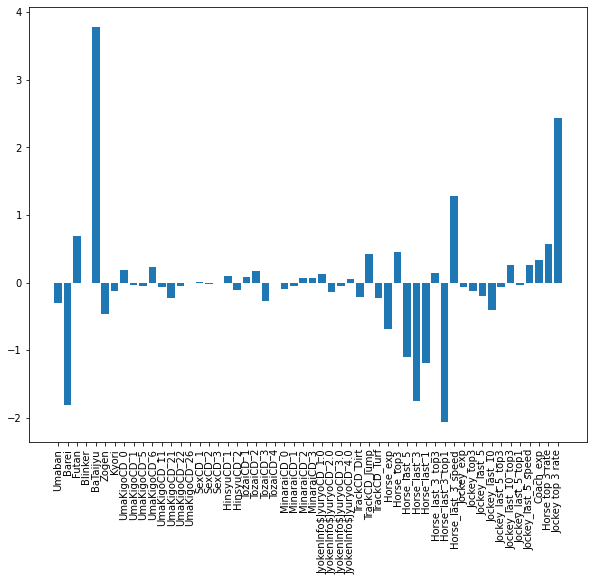

In [21]:
plt.figure(figsize=(10,8))
plt.bar(height=model_Log.coef_[0], x = X_train.columns)
xticks = plt.xticks(rotation=90)

## Better

In [22]:
X_train, X_test, y_train, y_test, top3_train, top3_test, raceid_train, raceid_test = split_data(df.reset_index(drop=True), target_col='Top 3',
                                                                                                drop_columns=drop_cols,
                                                                                                select_cols=None,
                                                                                                test_size=25402)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(500261, 55) (500261,)
(25402, 55) (25402,)


In [23]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [24]:
model_Log = LogisticRegression(max_iter=500, penalty='l2', C=0.1, class_weight='balanced')
model_Log.fit(X_train_sc, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=500)

In [32]:
top3_pred = predict_top3_prob(model_Log, X_test_sc, raceid_test)
print('Total accuracy:', accuracy_score(top3_test, top3_pred['Top 3']))
print('Top 3 prediction accuracy:', top3_accuracy_score(top3_test.values, top3_pred['Top 3'].values))

Total accuracy: 0.7797417526179041
Top 3 prediction accuracy: 0.46761363636363634


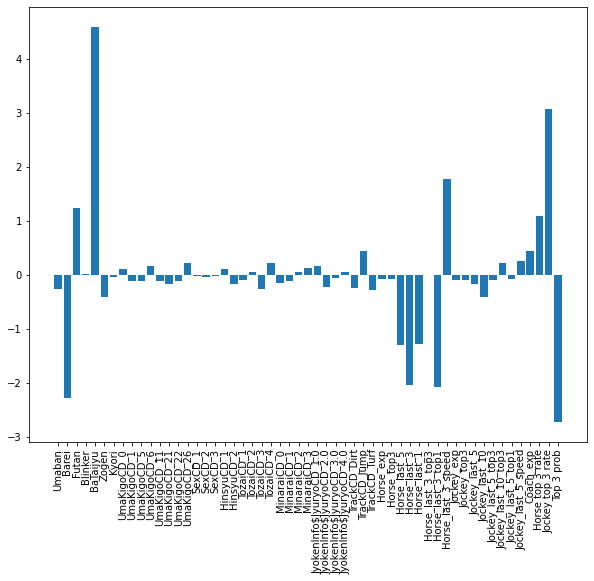

In [33]:
plt.figure(figsize=(10,8))
plt.bar(height=model_Log.coef_[0], x = X_train.columns)
xticks = plt.xticks(rotation=90)

# Error analysis

In [36]:
df_ = df[df['Top 3']].groupby('KettoNum')
groups = list(df_.groups.keys())
df_horse=df.groupby('KettoNum')
cols=['Time', 'KakuteiJyuni_fixed', 'Top 1', 'Top 3', 'Speed_fixed', 'Coach_exp','Horse_top3', 'Horse_exp','Horse_last_3_top3', 'Jockey_last_5_top3', 'Horse top 3 rate', 'Jockey top 3 rate']


In [38]:
df_horse.get_group(groups[np.random.randint(0, len(groups))])[cols]

,Time,KakuteiJyuni_fixed,Top 1,Top 3,Speed_fixed,Coach_exp,Horse_top3,Horse_exp,Horse_last_3_top3,Jockey_last_5_top3,Horse top 3 rate,Jockey top 3 rate
323144,883,60.400000,False,False,1.648123,367.0,0.0,0.0,6.000000e-01,1.0,0.00,0.139519
326203,1160,64.642857,False,False,1.613009,369.0,0.0,1.0,4.000000e-01,1.0,0.00,0.138112
328738,702,34.000000,False,False,1.702876,373.0,0.0,2.0,2.000000e-01,1.0,0.00,0.189885
335435,587,8.615385,False,True,1.770859,380.0,0.0,3.0,5.551115e-17,0.0,0.00,0.136752
337365,729,20.800000,False,False,1.711102,383.0,1.0,4.0,1.000000e+00,0.0,0.25,0.137107


# DNN model

In [30]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [47]:
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [48]:
model_nn.compile(loss = 'binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=['acc'])

In [49]:
callbacks = callbacks=[tf.keras.callbacks.ReduceLROnPlateau(fractions=0.1,monitor='loss', patience=3),
                       tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, min_delta=0.0001)]

In [50]:
history = model_nn.fit(X_train_sc, y_train,
                       epochs = 200,
                       batch_size=1024,
                       class_weight={0:0.2, 1:0.8},
                       callbacks=callbacks)

Epoch 1/200
489/489 [==============================] - 5s 9ms/step - loss: 0.2233 - acc: 0.6404 - lr: 0.0100
Epoch 2/200
489/489 [==============================] - 5s 10ms/step - loss: 0.1924 - acc: 0.6537 - lr: 0.0100
Epoch 3/200
489/489 [==============================] - 4s 9ms/step - loss: 0.1917 - acc: 0.6556 - lr: 0.0100
Epoch 4/200
489/489 [==============================] - 4s 9ms/step - loss: 0.1913 - acc: 0.6605 - lr: 0.0100
Epoch 5/200
489/489 [==============================] - 4s 9ms/step - loss: 0.1907 - acc: 0.6617 - lr: 0.0100
Epoch 6/200
489/489 [==============================] - 4s 8ms/step - loss: 0.1900 - acc: 0.6638 - lr: 0.0100
Epoch 7/200
489/489 [==============================] - 4s 9ms/step - loss: 0.1900 - acc: 0.6607 - lr: 0.0100
Epoch 8/200
489/489 [==============================] - 4s 9ms/step - loss: 0.1899 - acc: 0.6629 - lr: 0.0100
Epoch 9/200
489/489 [==============================] - 4s 9ms/step - loss: 0.1895 - acc: 0.6661 - lr: 0.0100
Epoch 10/200
489/4

In [51]:
top3_pred = predict_top3_prob(model_nn, X_test_sc, raceid_test)
print('Total accuracy:', accuracy_score(top3_test, top3_pred['Top 3']))
print('Top 3 prediction accuracy:', top3_accuracy_score(top3_test.values, top3_pred['Top 3'].values))

Total accuracy: 0.7836784505157074
Top 3 prediction accuracy: 0.47708333333333336


In [52]:
top3_pred = predict_top3_prob(model_nn, X_train_sc, raceid_train)
print('Total accuracy:', accuracy_score(top3_train, top3_pred['Top 3']))
print('Top 3 prediction accuracy:', top3_accuracy_score(top3_train.values, top3_pred['Top 3'].values))

Total accuracy: 0.7758969817755131
Top 3 prediction accuracy: 0.4590118127685815
